In [2]:
import sys
sys.path.insert(0, "/Users/sylvesteralberg/Desktop/Skole/Kandidat/Python for the Financial Economist/PythonGithubfiler")

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import animation, cm
import seaborn as sns

from scipy import stats
from scipy import optimize
from scipy.stats import norm, lognorm
from scipy.optimize import minimize
from functools import reduce
import matplotlib.ticker as mtick
from sympy import symbols, diff, solve, Eq

from statsmodels.tools.numdiff import approx_fprime, approx_hess

from typing import Union, List, Tuple

import cvxpy as cp

from codelib.statistics import moments as mom
from scipy.optimize import differential_evolution

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Buy-and-Hold versus Constant-Mix portfolios

# Expectations and variance of the portfolios

In [7]:
# Parameters
mu1, mu2 = 0.03, 0.06
sigma1, sigma2 = 0.075, 0.15
rho = 0.2
T = 5.0
dt = 0.01
num_paths = 1000
w1 = 0.3
w2 = 0.7
mu = np.array([mu1, mu2])
w = np.array([w1, w2])
h1 = 0.5
h2 = 0.5
h = np.array([h1, h2])
sigma_matrix = np.array([[sigma1**2, rho * sigma1 * sigma2], [rho * sigma1 * sigma2, sigma2**2]])
time_horizons = [12, 24, 60, 120]
num_assets = 2

In [8]:
#V_t (first portfolio)

# True Mean-Vector (over the time horizon T)
true_mean_vector = np.array([np.exp(mu1 * T + 0.5 * sigma1**2 * T), 
                             np.exp(mu2 * T + 0.5 * sigma2**2 * T)])

# True Variance-Covariance Matrix
true_cov_matrix = np.array([
    [(np.exp(sigma1**2 * T) - 1) * np.exp(2 * mu1 * T + sigma1**2 * T), 
     (np.exp(rho * sigma1 * sigma2 * T) - 1) * np.exp(mu1 * T + mu2 * T + 0.5 * (sigma1**2 + sigma2**2) * T)], 
    [(np.exp(rho * sigma1 * sigma2 * T) - 1) * np.exp(mu1 * T + mu2 * T + 0.5 * (sigma1**2 + sigma2**2) * T), 
     (np.exp(sigma2**2 * T) - 1) * np.exp(2 * mu2 * T + sigma2**2 * T)]
])

# Initial values
v0 = np.array([1.0, 1.0])

# Simulate paths using Monte Carlo
paths = np.zeros((num_paths, int(T/dt)+1, 2))
paths[:, 0, :] = v0

for i in range(1, int(T/dt)+1):
    dZ = np.random.randn(num_paths, 2) * np.sqrt(dt)
    paths[:, i, 0] = paths[:, i-1, 0] * np.exp((mu1 - 0.5 * sigma1**2) * dt + sigma1 * dZ[:, 0])
    paths[:, i, 1] = paths[:, i-1, 1] * np.exp((mu2 - 0.5 * sigma2**2) * dt + sigma2 * (rho * dZ[:, 0] + np.sqrt(1 - rho**2) * dZ[:, 1]))

final_values = paths[:, -1, :]

mean_Vt = np.mean(final_values, axis=0)
cov_Vt = np.cov(final_values.T)

print("True Mean:", true_mean_vector)
print("Monte Carlo Mean:", mean_Vt)
print("True Covariance Matrix:")
print(true_cov_matrix)
print("Monte Carlo Covariance Matrix:")
print(cov_Vt)

True Mean: [1.17828796 1.42796449]
Monte Carlo Mean: [1.16205515 1.3268813 ]
True Covariance Matrix:
[[0.03960199 0.0190356 ]
 [0.0190356  0.24279817]]
Monte Carlo Covariance Matrix:
[[0.03737558 0.01609693]
 [0.01609693 0.2027182 ]]


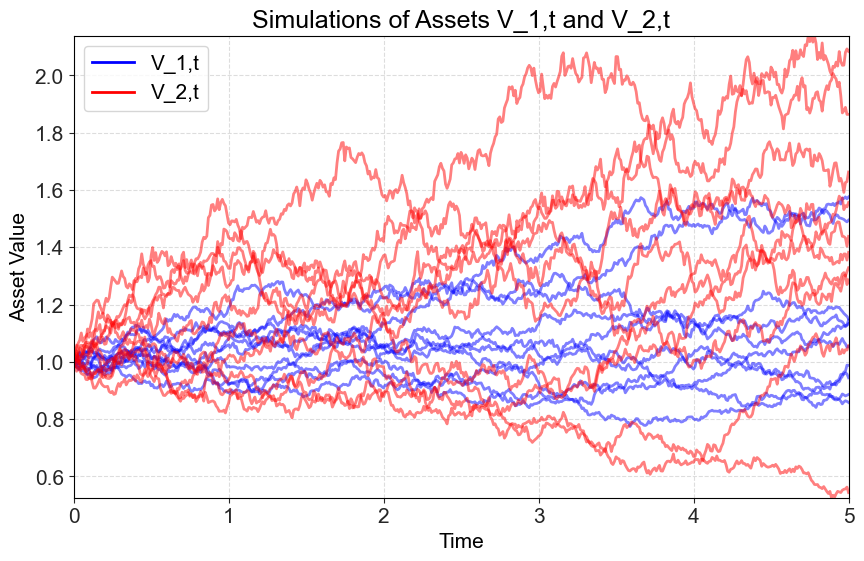

In [9]:
# Plotting the simulated paths of the two assets in the portfolio V_t
time_steps = np.arange(0, T + dt, dt)

plt.figure(figsize=(10, 6))

# Plotting the paths for V_1,t
for path in paths[:10, :, 0]:
    plt.plot(time_steps, path, alpha=0.5, color='blue')

# Plotting the paths for V_2,t
for path in paths[:10, :, 1]:
    plt.plot(time_steps, path, alpha=0.5, color='red')
plt.plot([], [], color='blue', label='V_1,t')
plt.plot([], [], color='red', label='V_2,t')
plt.title('Simulations of Assets V_1,t and V_2,t')
plt.xlabel('Time')
plt.ylabel('Asset Value')
plt.legend()
plt.show()

In [12]:
#Constant-mix

# Calculate theoretical mean and variance for the log-normal distribution
log_mean = np.dot(w, mu) * T
log_sd = np.sqrt(np.dot(np.dot(w, sigma_matrix), w)) * np.sqrt(T)
theoretical_mean = np.exp(log_mean + 0.5 * log_sd**2)
theoretical_variance = (np.exp(log_sd**2) - 1) * np.exp(2 * log_mean + log_sd**2)

# Portfolio dynamics simulation
num_paths = 1000
pathsCM = np.zeros((num_paths, int(T/dt)+1))
pathsCM[:, 0] = 1

for i in range(1, int(T/dt)+1):
    dZ = np.random.randn(num_paths) * np.sqrt(dt)
    pathsCM[:, i] = pathsCM[:, i-1] * (1 + np.dot(w, mu) * dt + np.sqrt(np.dot(np.dot(w, sigma_matrix), w)) * dZ)

final_valuesCM = pathsCM[:, -1]

mean_VtCM = np.mean(final_valuesCM)
variance_VtCM = np.var(final_valuesCM)

percentiles = [10, 25, 50, 75, 90]

empirical_percentiles = [np.percentile(final_valuesCM, p) for p in percentiles]

# Theoretical percentiles using log-normal distribution
theoretical_percentiles = [lognorm.ppf(p/100, s=log_sd, scale=np.exp(log_mean)) for p in percentiles]

print("Theoretical Mean:", theoretical_mean)
print("Monte-Carlo Mean:", mean_VtCM)
print("Theoretical Variance:", theoretical_variance)
print("Monte-Carlo Variance:", variance_VtCM)
print("Theoretical Percentiles:", theoretical_percentiles)
print("Monte-Carlo Percentiles:", empirical_percentiles)

Theoretical Mean: 1.331346218937657
Monte-Carlo Mean: 1.2879758361659028
Theoretical Variance: 0.11409127223625398
Monte-Carlo Variance: 0.10266771912496063
Theoretical Percentiles: [0.9369893356578985, 1.0903926164137974, 1.2904616208728898, 1.5272399774889143, 1.7772787069946927]
Monte-Carlo Percentiles: [0.9216474445651043, 1.0655787077548546, 1.2526644762757857, 1.4562125076153696, 1.706931493554196]


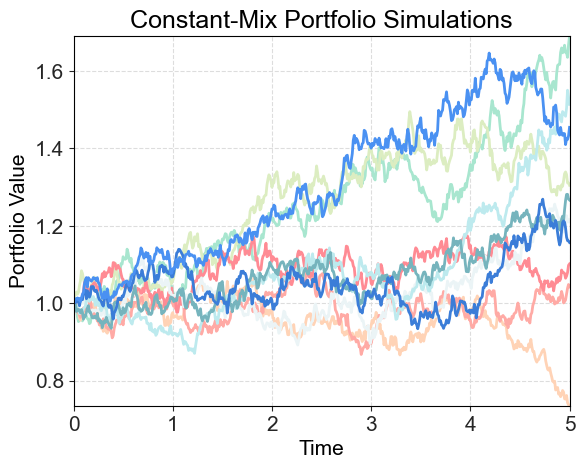

In [14]:
# Plotting the portfolio paths
time_steps = np.arange(0, T+dt, dt)
for path in pathsCM[:10]:
    plt.plot(time_steps, path, alpha=1)

plt.title('Constant-Mix Portfolio Simulations')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.show()

In [15]:
#Buy and hold portfolio
# Calculate theoretical mean and variance for the log-normal distribution
log_mean_bh = np.dot(h, mu) * T
log_sd_bh = np.sqrt(np.dot(np.dot(np.transpose(h), sigma_matrix), h) * T)  # Adjust for total time horizon
theoretical_mean_bh = np.exp(log_mean_bh + 0.5 * log_sd_bh**2)
theoretical_variance_bh = (np.exp(log_sd_bh**2) - 1) * np.exp(2 * log_mean_bh + log_sd_bh**2)

# Portfolio dynamics simulation for Buy-and-Hold
pathsBH = np.zeros((num_paths, int(T/dt)+1, 2))
pathsBH[:, 0, :] = v0

for i in range(1, int(T/dt)+1):
    dZ = np.random.randn(num_paths, 2) * np.sqrt(dt)
    pathsBH[:, i, 0] = pathsBH[:, i-1, 0] * (1 + mu1 * dt + sigma1 * dZ[:, 0])
    pathsBH[:, i, 1] = pathsBH[:, i-1, 1] * (1 + mu2 * dt + sigma2 * (rho * dZ[:, 0] + np.sqrt(1 - rho**2) * dZ[:, 1]))

final_valuesBH = np.dot(pathsBH[:, -1, :], h)

mean_VtBH = np.mean(final_valuesBH)
variance_VtBH = np.var(final_valuesBH)

print("Theoretical Mean:", theoretical_mean_bh)
print("Monte-Carlo Mean:", mean_VtBH)
print("Theoretical Variance:", theoretical_variance_bh)
print("Monte-Carlo Variance:", variance_VtBH)

Theoretical Mean: 1.278120481517821
Monte-Carlo Mean: 1.2619203929868146
Theoretical Variance: 0.06799700004797252
Monte-Carlo Variance: 0.07279257674906361


# Mean and minimum variance Buy-and-hold

In [23]:
# Parameters
mu1, mu2 = 0.03, 0.06
sigma1, sigma2 = 0.075, 0.15
rho = 0.2
T = 1.0
dt = 0.001
num_paths = 10000
h1 = 0.5
h2 = 0.5
h = np.array([h1, h2])
sigma_matrix = np.array([[sigma1**2, rho * sigma1 * sigma2], [rho * sigma1 * sigma2, sigma2**2]])
time_horizons = [12, 24, 60, 120]
num_assets = 2

In [24]:
#V_t (first portfolio)

# True Mean-Vector (over the time horizon T)
true_mean_vector = np.array([np.exp(mu1 * T + 0.5 * sigma1**2 * T), 
                             np.exp(mu2 * T + 0.5 * sigma2**2 * T)])

# True Variance-Covariance Matrix
true_cov_matrix = np.array([
    [(np.exp(sigma1**2 * T) - 1) * np.exp(2 * mu1 * T + sigma1**2 * T), 
     (np.exp(rho * sigma1 * sigma2 * T) - 1) * np.exp(mu1 * T + mu2 * T + 0.5 * (sigma1**2 + sigma2**2) * T)], 
    [(np.exp(rho * sigma1 * sigma2 * T) - 1) * np.exp(mu1 * T + mu2 * T + 0.5 * (sigma1**2 + sigma2**2) * T), 
     (np.exp(sigma2**2 * T) - 1) * np.exp(2 * mu2 * T + sigma2**2 * T)]
])

v0 = np.array([1.0, 1.0])

# Simulate paths using Monte Carlo
paths = np.zeros((num_paths, int(T/dt)+1, 2))
paths[:, 0, :] = v0

for i in range(1, int(T/dt)+1):
    dZ = np.random.randn(num_paths, 2) * np.sqrt(dt)
    paths[:, i, 0] = paths[:, i-1, 0] * np.exp((mu1 - 0.5 * sigma1**2) * dt + sigma1 * dZ[:, 0])
    paths[:, i, 1] = paths[:, i-1, 1] * np.exp((mu2 - 0.5 * sigma2**2) * dt + sigma2 * (rho * dZ[:, 0] + np.sqrt(1 - rho**2) * dZ[:, 1]))

final_values = paths[:, -1, :]

mean_Vt = np.mean(final_values, axis=0)
cov_Vt = np.cov(final_values.T)

print("True Mean:", true_mean_vector)
print("Monte Carlo Mean:", mean_Vt)
print("True Covariance Matrix:")
print(true_cov_matrix)
print("Monte Carlo Covariance Matrix:")
print(cov_Vt)

True Mean: [1.03335677 1.07384965]
Monte Carlo Mean: [1.0305901  1.06149432]
True Covariance Matrix:
[[0.00602345 0.00249957]
 [0.00249957 0.02624004]]
Monte Carlo Covariance Matrix:
[[0.00598564 0.0024231 ]
 [0.0024231  0.02534895]]


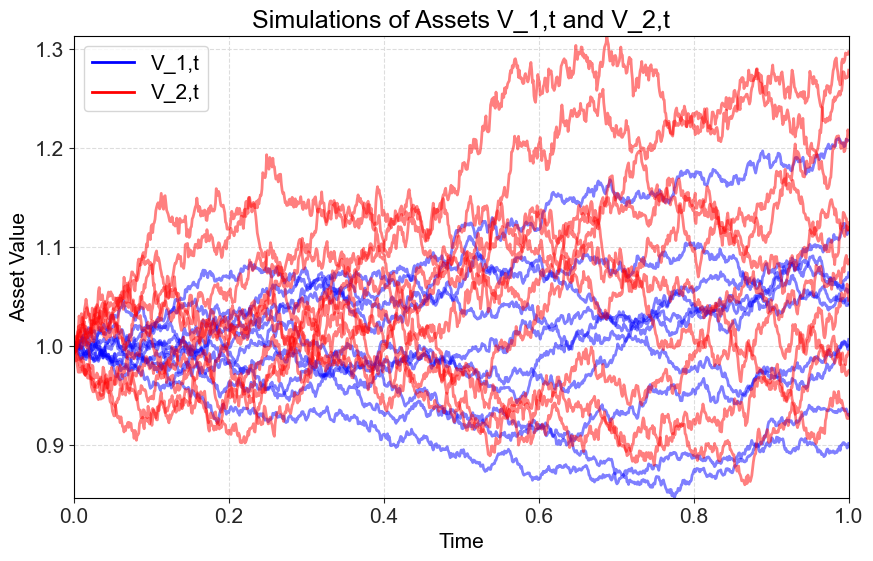

In [25]:
# Plotting the simulated paths of the two assets in the portfolio V_t
time_steps = np.arange(0, T + dt, dt)

plt.figure(figsize=(10, 6))

# Plotting the paths for V_1,t
for path in paths[:10, :, 0]:
    plt.plot(time_steps, path, alpha=0.5, color='blue')

# Plotting the paths for V_2,t
for path in paths[:10, :, 1]:
    plt.plot(time_steps, path, alpha=0.5, color='red')
plt.plot([], [], color='blue', label='V_1,t')
plt.plot([], [], color='red', label='V_2,t')
plt.title('Simulations of Assets V_1,t and V_2,t')
plt.xlabel('Time')
plt.ylabel('Asset Value')
plt.legend()
plt.show()

In [26]:
# Mean-Variance Optimization for a specific mu_target
mu_target = np.exp(0.05 * T)

h = cp.Variable(2)
portfolio_mean = h @ mean_Vt
portfolio_variance = cp.quad_form(h, cov_Vt)

constraints = [h >= 0, cp.sum(h) == 1, portfolio_mean == mu_target]
prob = cp.Problem(cp.Minimize(portfolio_variance), constraints)
prob.solve()

optimal_holdings = h.value

print("Optimal Holdings:", optimal_holdings)

Optimal Holdings: [0.33080349 0.66919651]


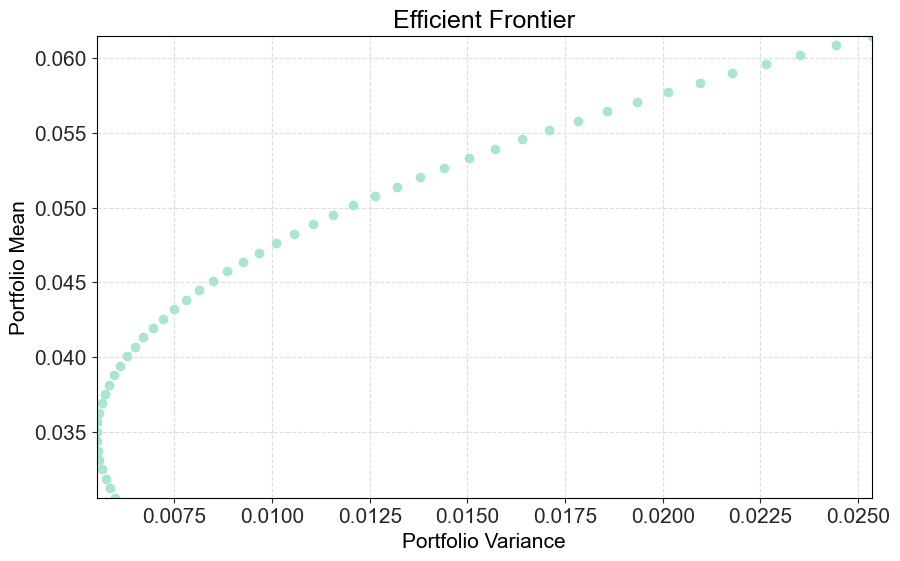

In [27]:
# Efficient frontier simulation
holdings_range = np.linspace(0, 1, 50)

portfolio_means = []
portfolio_variances = []

for holding in holdings_range:
    h1, h2 = holding, 1 - holding

    portfolio_values = h1 * paths[:, :, 0] + h2 * paths[:, :, 1]

    final_portfolio_values = portfolio_values[:, -1]
    
    annualized_returns = (final_portfolio_values ** (1 / T)) - 1

    portfolio_mean = np.mean(annualized_returns)
    portfolio_variance = np.var(annualized_returns)

    portfolio_means.append(portfolio_mean)
    portfolio_variances.append(portfolio_variance)
        
# Plotting the Efficient Frontier
plt.figure(figsize=(10, 6))
plt.plot(portfolio_variances, portfolio_means, 'o')
plt.title('Efficient Frontier')
plt.xlabel('Portfolio Variance')
plt.ylabel('Portfolio Mean')

plt.ylim(min(portfolio_means), max(portfolio_means))
plt.xlim(min(portfolio_variances), max(portfolio_variances))

plt.show()

In [25]:
#5year metrics calculations
optimized_weights = h.value

expected_cumulative_return_5yr = 1.28403
annualized_expected_return = (expected_cumulative_return_5yr)**(1/T) - 1

holding = np.array([[0.3336484, 0.6663516]])

# Portfolio Variance and Standard Deviation (annualized)
portfolio_variance = holding @ sigma_matrix @ holding.T * T
portfolio_std_dev = portfolio_variance**0.5

# Contribution to Portfolio Risk
asset_contributions = holding @sigma_matrix @ holding.T
relative_contributions = asset_contributions / portfolio_std_dev
individual_contributions = np.array([optimal_holdings[i] * sigma_matrix[i, :] @ optimal_holdings.T for i in range(len(optimized_weights))]) / portfolio_std_dev

print("Annualized Expected Return:", annualized_expected_return)
print("Portfolio Variance:", portfolio_variance)
print("Portfolio Standard Deviation:", portfolio_std_dev)
print("Individual Contributions to Portfolio Risk:", individual_contributions)

Annualized Expected Return: 0.28403
Portfolio Variance: [[0.0116172]]
Portfolio Standard Deviation: [[0.10778314]]
Individual Contributions to Portfolio Risk: [[0.01143404 0.09115642]]


In [28]:
# Minimum variance Buy and Hold
h = cp.Variable(2)
portfolio_variance = cp.quad_form(h, cov_Vt)

constraints = [h >= 0, cp.sum(h) == 1]
prob = cp.Problem(cp.Minimize(portfolio_variance), constraints)
prob.solve()

optimal_holdings_min_variance = h.value

print("Optimal Holdings for Minimum Variance Portfolio:", optimal_holdings_min_variance)

Optimal Holdings for Minimum Variance Portfolio: [0.86550559 0.13449441]


# Mean and minimum variance Buy-and-hold

In [15]:
# Parameters
mu1, mu2 = 0.03, 0.06
sigma1, sigma2 = 0.075, 0.15
rho = 0.2
T = 5.0
num_paths = 10000
mu = np.array([mu1*T, mu2*T])
cov_mat = np.array([[sigma1**2*T, rho * sigma1 * sigma2*T], [rho * sigma1 * sigma2*T, sigma2**2*T]])
num_assets = 2
asset_names = ["V1","V2"]

mu_l = mom.calculate_log_norm_mean(mu, cov_mat) - 1.0
sigma_l = mom.calculate_log_norm_cov_mat(mu, cov_mat)

In [16]:
#Defining the mean varince problem

return_targets = np.linspace(np.min(mu_l), np.max(mu_l), 100)

mu_target = cp.exp(0.05*T)-1

w = cp.Variable(num_assets)

# define constraints 
constraints = [w >= 0]
constraints.append(cp.sum(w) == 1)
constraints.append(w @ mu_l == mu_target)

# define problem 
variance = cp.quad_form(w, sigma_l, assume_PSD=True)
prob =  cp.Problem(cp.Minimize(variance), constraints)

optimal_portfolios = []

prob.solve(verbose=False)
    
optimal_portfolios.append(w.value)
    
w.value

array([0.57650222, 0.42349778])

In [17]:
#5year metric calculations
optimal_weights = np.array([0.57650222, 0.42349778])

expected_cumulative_return_5yr = 1.28403
annualized_expected_return = (expected_cumulative_return_5yr)**(1/T) - 1

# Portfolio Variance and Standard Deviation (annualized)
portfolio_variance = np.dot(optimal_weights, np.dot(cov_mat, optimal_weights.T))
portfolio_std_dev = np.sqrt(portfolio_variance)

# Contribution to Portfolio Risk
asset_contributions = optimal_weights * np.dot(cov_mat, optimal_weights.T)
relative_contributions = asset_contributions / portfolio_std_dev

print("Annualized Expected Return:", annualized_expected_return)
print("Portfolio Variance:", portfolio_variance)
print("Portfolio Standard Deviation:", portfolio_std_dev)
print("Contribution to Portfolio Risk:", relative_contributions)

Annualized Expected Return: 0.051271846874691995
Portfolio Variance: 0.03501771234166966
Portfolio Standard Deviation: 0.18713020157545296
Contribution to Portfolio Risk: [0.06462953 0.12250067]


In [19]:
#Constant mix, optimal weights for the minimum variance problem

time_horizons = [12, 36, 60, 120]
num_assets = 2
num_sim = 1000
sigma1 = 0.075
sigma2 = 0.15
rho = 0.2

cov_mat_true = np.array([[sigma1**2, sigma1*sigma2*rho],
                     [sigma1*sigma2*rho, sigma2**2]])
results = {}

In [20]:
#Defining and solving the minimum variance
w = cp.Variable(num_assets)

constraints = [w >= 0]
constraints.append(cp.sum(w) == 1)

for T in time_horizons:
    opt_weights = []
    for i in range(num_sim): 
    
        cov_mat = stats.wishart.rvs(df=T-1, scale= cov_mat_true / T, size=1)
    
        variance = cp.quad_form(w, cov_mat, assume_PSD=True)
        prob =  cp.Problem(cp.Minimize(variance), constraints)
    
        prob.solve()
    
        opt_weights.append(w.value)

    opt_weights = np.array(opt_weights)
    mean_opt_weights = np.mean(opt_weights[:, :], axis=0)
    results[T] = mean_opt_weights
    
print(results)

{12: array([0.83097903, 0.16902097]), 36: array([0.85490931, 0.14509069]), 60: array([0.86158177, 0.13841823]), 120: array([0.85775022, 0.14224978])}


# Portfolio insurance strategies

# Value and distribution of the bank account

In [33]:
#Find initial value of bank account
dt = 1
horizon=5
def simulate_vasicek(r0, kappa, theta, beta, horizon, dt, num_sim):
    num_steps = int(horizon / dt)
    rates = np.zeros((num_steps + 1, num_sim))
    rates[0, :] = r0
    for step in range(1, num_steps + 1):
        dr = kappa * (theta - rates[step - 1, :]) * dt + beta * np.sqrt(dt) * np.random.normal(size=num_sim)
        rates[step, :] = rates[step - 1, :] + dr
    # Convert rates to the bank account values (compounding)
    bank_account_values = np.cumprod(1 + rates, axis=0)
    return bank_account_values

bank_account_values = simulate_vasicek(r0=0.03, kappa=1, theta=0.03, beta=0.02, horizon=5, dt=dt, num_sim=1000000)

time_points = np.arange(0, horizon + dt, dt)

mean_bank_account_value = np.mean(bank_account_values[-1, :])

mean_bank_account_value

1.1940354671244646

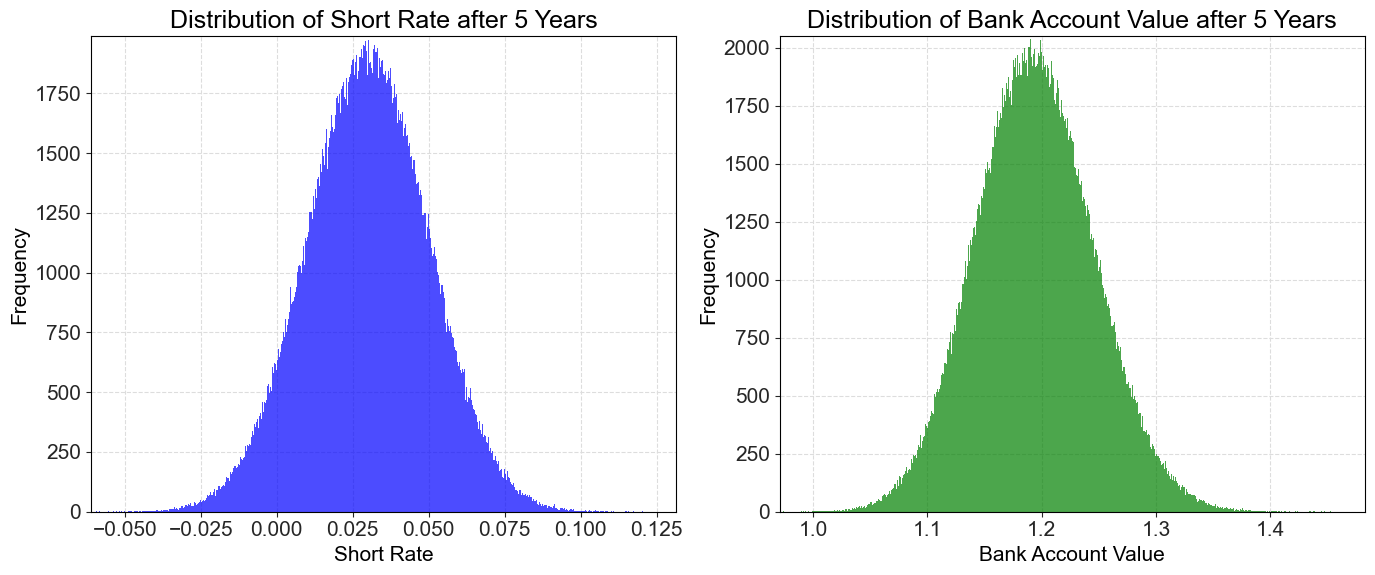

In [34]:
# Modified simulate_vasicek function to return both rates and bank_account_values
def simulate_vasicek(r0, kappa, theta, beta, horizon, dt, num_sim):
    num_steps = int(horizon / dt)
    rates = np.zeros((num_steps + 1, num_sim))
    rates[0, :] = r0
    for step in range(1, num_steps + 1):
        dr = kappa * (theta - rates[step - 1, :]) * dt + beta * np.sqrt(dt) * np.random.normal(size=num_sim)
        rates[step, :] = rates[step - 1, :] + dr
    bank_account_values = np.cumprod(1 + rates, axis=0)
    return rates, bank_account_values

# Run the simulation to get both rates and bank_account_values
rates, bank_account_values = simulate_vasicek(r0=0.03, kappa=1, theta=0.03, beta=0.02, horizon=5, dt=dt, num_sim=1000000)

plt.figure(figsize=(14, 6))
# Distribution of the short rate at the end of the period
plt.subplot(1, 2, 1)
plt.hist(rates[-1, :], bins=2000, color='blue', alpha=0.7)
plt.title('Distribution of Short Rate after 5 Years')
plt.xlabel('Short Rate')
plt.ylabel('Frequency')

# Distribution of bank account values at the end of the period
plt.subplot(1, 2, 2)
plt.hist(bank_account_values[-1, :], bins=2000, color='green', alpha=0.7)
plt.title('Distribution of Bank Account Value after 5 Years')
plt.xlabel('Bank Account Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Optimization of utility

In [37]:
h1, h2, λ, V1t, V2t = symbols('h1 h2 λ V1t V2t')

# Function to simulate Geometric Brownian Motion V_1,t
def simulate_gbm(mu, sigma, T, dt, num_sim):
    num_steps = int(T / dt)
    asset_prices = np.zeros((num_steps + 1, num_sim))
    asset_prices[0, :] = 1
    for step in range(1, num_steps + 1):
        dz = np.random.normal(size=num_sim)
        asset_prices[step, :] = asset_prices[step - 1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dz)
    return asset_prices

risky_asset = simulate_gbm(mu=0.06, sigma=0.15, T=5, dt=1/252, num_sim=5000)
V1t = np.mean(risky_asset)

#Function to simulate Vasicek model for risk-free rate
def simulate_vasicek(r0, kappa, theta, beta, horizon, dt, num_sim):
    num_steps = int(horizon / dt)
    rates = np.zeros((num_steps + 1, num_sim))
    rates[0, :] = r0
    for step in range(1, num_steps + 1):
        dr = kappa * (theta - rates[step - 1, :]) * dt + beta * np.sqrt(dt) * np.random.normal(size=num_sim)
        rates[step, :] = rates[step - 1, :] + dr
    return rates

rates = np.cumprod(1+simulate_vasicek(r0=0.03, kappa=1, theta=0.03, beta=0.02, horizon=5, dt=1, num_sim=5000),axis=0)
V2t = np.mean(rates)

In [38]:
## Find solution:

################ Buy-and-Hold ###################

total_investment = 1000000

# The Lagrange function
L = -(1/(h1*V1t)) - (1/(h2*V2t)) - λ * (h1 + h2 - total_investment)

# First order conditions
dL_dh1 = diff(L, h1)
dL_dh2 = diff(L, h2)
dL_dλ = diff(L, λ)

solutions = solve((dL_dh1, dL_dh2, dL_dλ), (h1, h2, λ), dict=True)

if len(solutions) > 1:
    second_solution = solutions[1]
    print("Buy-and-Hold solution:", second_solution)
else:
    print("Only one solution found:", solutions[0])

Buy-and-Hold solution: {h1: 494000.326338674, h2: 505999.673661326, λ: 3.51821696348386e-12}


Mean of Buy-and-Hold portfolio value: 1093530.02531838


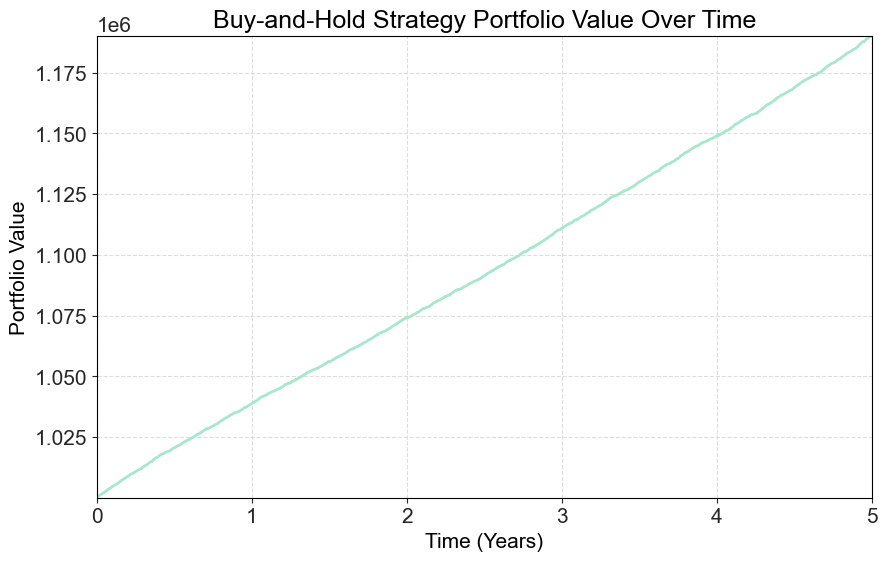

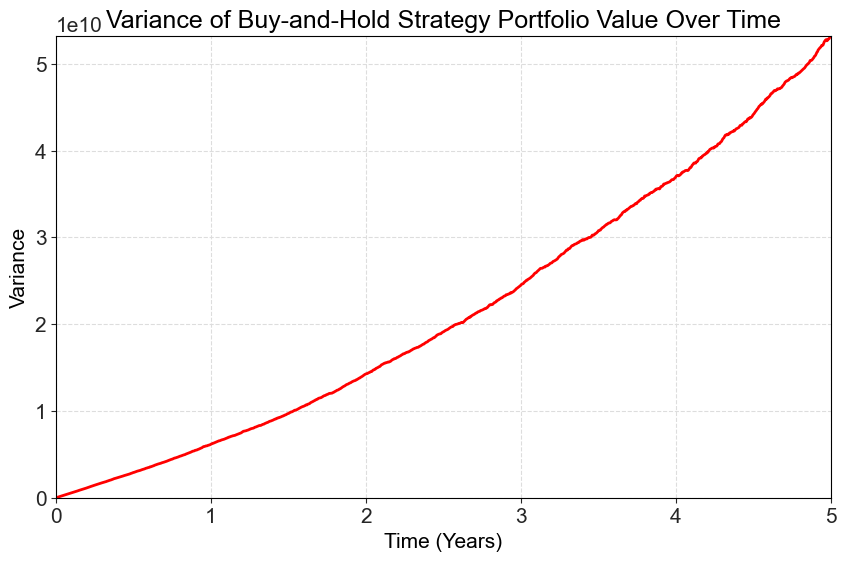

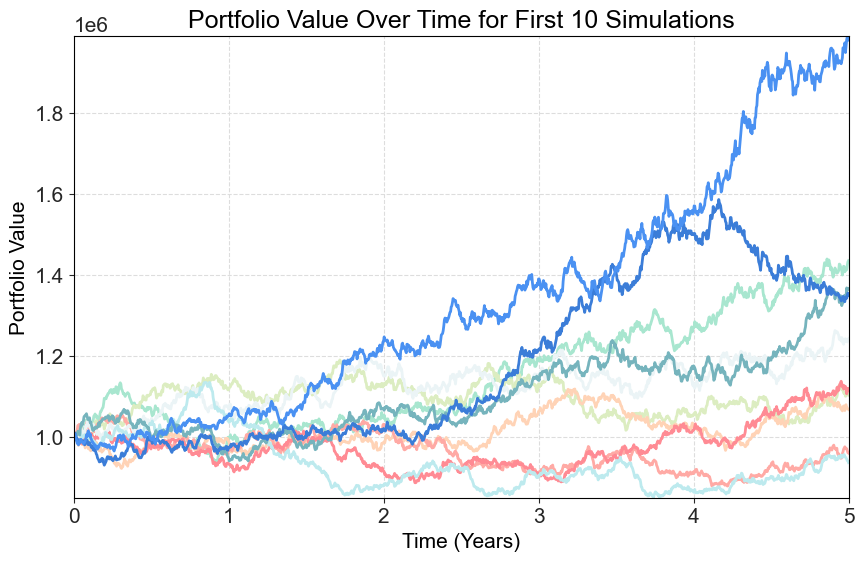

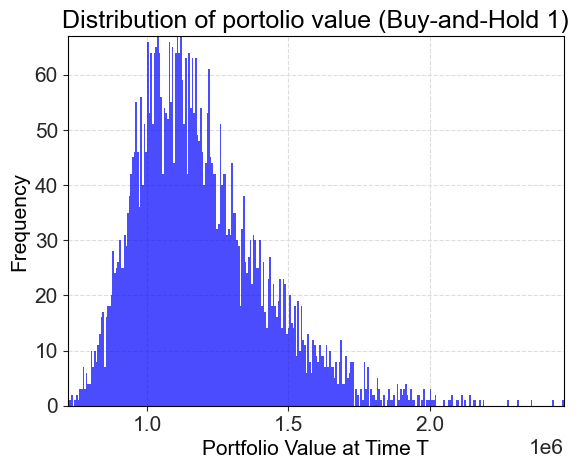

Sample mean of Portfolio at Time T: 1190240.0597146153
Sample variance of Portfolio at Time T: 53235431951.94146


In [39]:
## Plot:

############# buy-and-hold #############

rates_plot = 1+simulate_vasicek(r0=0.03/252, kappa=1, theta=0.03, beta=0.02, horizon=5, dt=1/252, num_sim=5000)

h1_optimal = second_solution[h1].evalf()
h2_optimal = second_solution[h2].evalf()

portfolio_value = h1_optimal * risky_asset + h2_optimal * rates_plot

mean_portfolio_value = np.mean(portfolio_value, axis=1)

print("Mean of Buy-and-Hold portfolio value:",np.mean(mean_portfolio_value))

time_points = np.linspace(0, 5, len(mean_portfolio_value))

#Plotting mean of the portfolio
plt.figure(figsize=(10, 6))
plt.plot(time_points, mean_portfolio_value)
plt.xlabel('Time (Years)')
plt.ylabel('Portfolio Value')
plt.title('Buy-and-Hold Strategy Portfolio Value Over Time')
plt.show()

variance_portfolio_value = np.var(portfolio_value, axis=1)

#Plotting variance
plt.figure(figsize=(10, 6))
plt.plot(time_points, variance_portfolio_value, color='red')
plt.xlabel('Time (Years)')
plt.ylabel('Variance')
plt.title('Variance of Buy-and-Hold Strategy Portfolio Value Over Time')
plt.show()

portfolio_value_first_10 = portfolio_value[:, :10]

time_points = np.linspace(0, 5, portfolio_value_first_10.shape[0])  # Assuming a 5 year period

# Plotting the portfolio values
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(time_points, portfolio_value_first_10[:, i])

plt.xlabel('Time (Years)')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time for First 10 Simulations')
plt.show()

portfolio_values1 = np.zeros_like(risky_asset)

for t in range(risky_asset.shape[0]):
    portfolio_values1[t, :] = h1_optimal * risky_asset[t, :] + h2_optimal * rates_plot[t, :]

portfolio_value_at_T1 = portfolio_values1[-1, :]

# Histogram of the final portfolio values
plt.hist(portfolio_value_at_T1, bins=300, alpha=0.7, color='blue')
plt.title('Distribution of portolio value (Buy-and-Hold 1)')
plt.xlabel('Portfolio Value at Time T')
plt.ylabel('Frequency')
plt.show()

# Estimating the mean and variance
mean_portfolio_at_T1 = np.mean(portfolio_value_at_T1)
variance_portfolio_at_T1 = np.var(portfolio_value_at_T1)

print("Sample mean of Portfolio at Time T:", mean_portfolio_at_T1)
print("Sample variance of Portfolio at Time T:", variance_portfolio_at_T1)

In [40]:
h1, h2, λ, μ, V1t, V2t, s = symbols('h1 h2 λ μ V1t V2t s')

# Function to simulate Geometric Brownian Motion V_1,t
def simulate_gbm(mu, sigma, T, dt, num_sim):
    num_steps = int(T / dt)
    asset_prices = np.zeros((num_steps + 1, num_sim))
    asset_prices[0, :] = 1
    for step in range(1, num_steps + 1):
        dz = np.random.normal(size=num_sim)
        asset_prices[step, :] = asset_prices[step - 1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dz)
    return asset_prices

risky_asset = simulate_gbm(mu=0.06, sigma=0.15, T=5, dt=1/252, num_sim=5000)
V1t = np.mean(risky_asset)

#Function to simulate Vasicek model for risk-free rate
def simulate_vasicek(r0, kappa, theta, beta, horizon, dt, num_sim):
    num_steps = int(horizon / dt)
    rates = np.zeros((num_steps + 1, num_sim))
    rates[0, :] = r0
    for step in range(1, num_steps + 1):
        dr = kappa * (theta - rates[step - 1, :]) * dt + beta * np.sqrt(dt) * np.random.normal(size=num_sim)
        rates[step, :] = rates[step - 1, :] + dr
    return rates

rates = np.cumprod(1+simulate_vasicek(r0=0.03, kappa=1, theta=0.03, beta=0.02, horizon=5, dt=1, num_sim=5000),axis=0)
V2t = np.mean(rates)

In [41]:
## Find solution:
################ Buy-and-Hold 2 ###################

total_investment = 1000000

# The Lagrange function
L = -(1/(h1*V1t)) - (1/(h2*V2t)) - λ * (h1 + h2 - total_investment) - μ * (h1 * V1t + h2 * V2t - 700000 * V2t - s)

# First order conditions
dL_dh1 = diff(L, h1)
dL_dh2 = diff(L, h2)
dL_dλ = diff(L, λ)
dL_dμ = diff(L, μ)
dL_ds = diff(L, s)

solutions2 = solve((dL_dh1, dL_dh2, dL_dλ, dL_dμ, dL_ds), (h1, h2, λ, μ, s), dict=True)

if len(solutions2) > 1:
    second_solution2 = solutions2[1]
    print("Buy-and-Hold solution:", second_solution2)
else:
    print("Only one solution found:", solutions2[0])

Buy-and-Hold solution: {h1: 493595.617096385, h2: 506404.382903615, s: 361873.584718342, λ: 3.51236048007103e-12, μ: 0.0}


Mean of Buy-and-Hold 2 portfolio value: 1095407.01921391


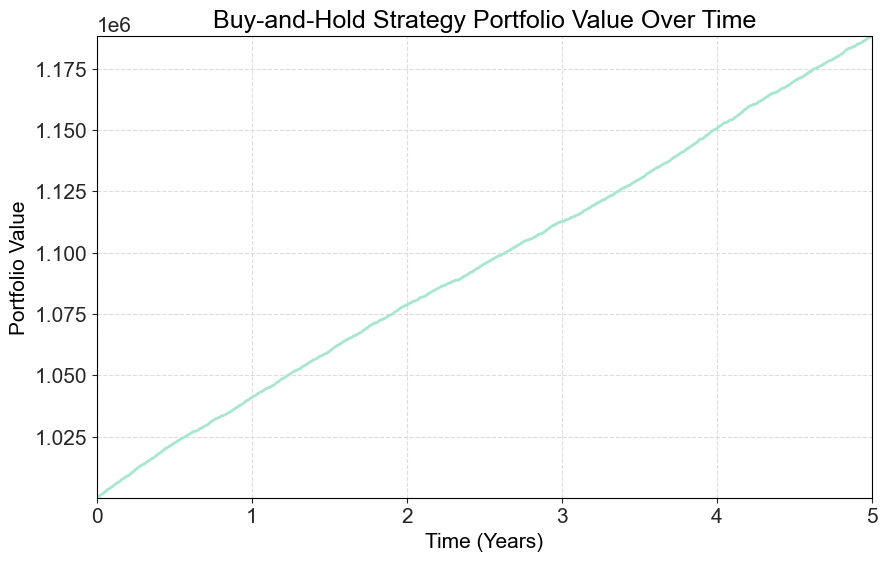

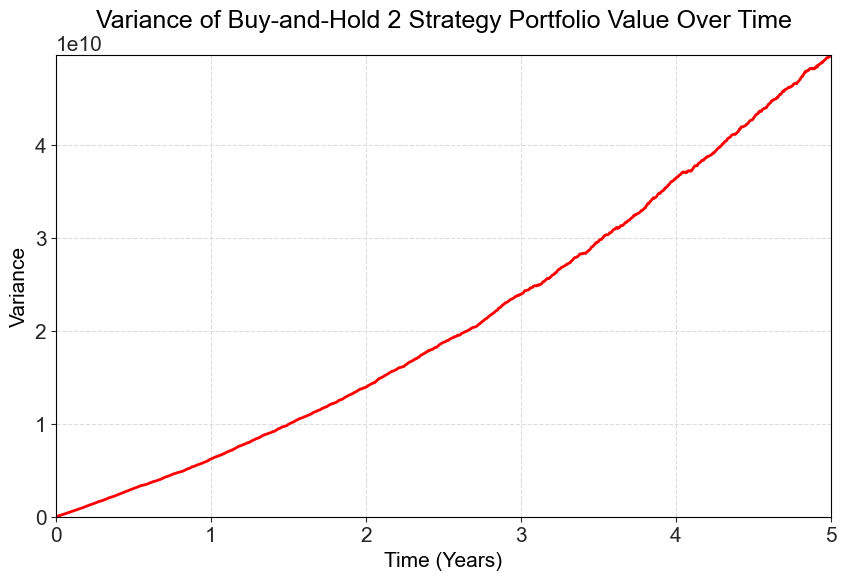

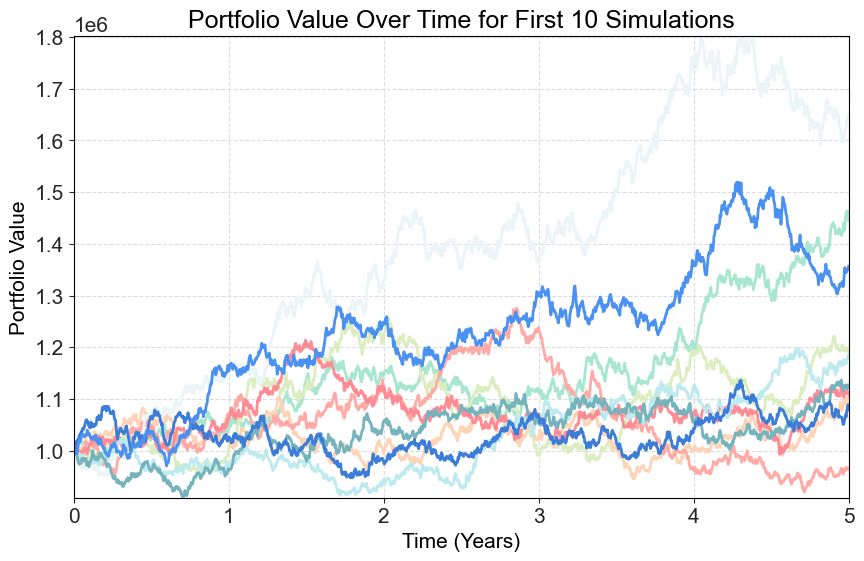

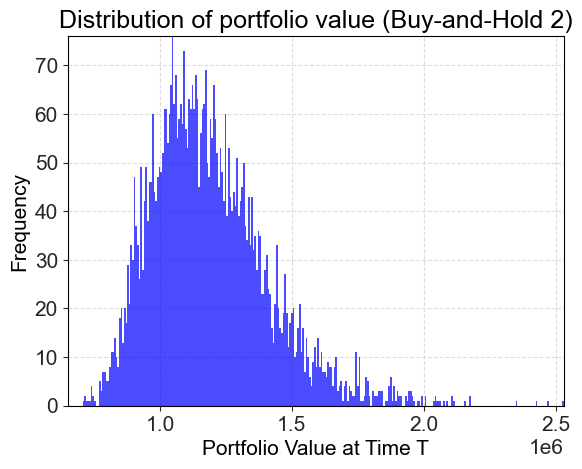

Sample mean of Portfolio at Time T: 1188421.1816978783
Sample variance of Portfolio at Time T: 49670071936.45038


In [42]:
## Plot:

############# buy-and-hold 2#############

rates_plot = 1+simulate_vasicek(r0=0.03/252, kappa=1, theta=0.03, beta=0.02, horizon=5, dt=1/252, num_sim=5000)

h1_optimal2 = second_solution2[h1].evalf()
h2_optimal2 = second_solution2[h2].evalf()

portfolio_value2 = h1_optimal2 * risky_asset + h2_optimal2 * rates_plot

mean_portfolio_value2 = np.mean(portfolio_value2, axis=1)

print("Mean of Buy-and-Hold 2 portfolio value:",np.mean(mean_portfolio_value2))

time_points = np.linspace(0, 5, len(mean_portfolio_value2))

#Plotting mean of the portfolio value
plt.figure(figsize=(10, 6))
plt.plot(time_points, mean_portfolio_value2)
plt.xlabel('Time (Years)')
plt.ylabel('Portfolio Value')
plt.title('Buy-and-Hold Strategy Portfolio Value Over Time')
plt.show()

variance_portfolio_value2 = np.var(portfolio_value2, axis=1)

#Plotting variance
plt.figure(figsize=(10, 6))
plt.plot(time_points, variance_portfolio_value2, color='red')
plt.xlabel('Time (Years)')
plt.ylabel('Variance')
plt.title('Variance of Buy-and-Hold 2 Strategy Portfolio Value Over Time')
plt.show()

portfolio_value_first_10_2 = portfolio_value2[:, :10]

time_points = np.linspace(0, 5, portfolio_value_first_10_2.shape[0])

# Plotting portfolio values
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(time_points, portfolio_value_first_10_2[:, i])
plt.xlabel('Time (Years)')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time for First 10 Simulations')
plt.show()

portfolio_values = np.zeros_like(risky_asset)

for t in range(risky_asset.shape[0]):
    portfolio_values[t, :] = h1_optimal2 * risky_asset[t, :] + h2_optimal2 * rates_plot[t, :]

portfolio_value_at_T = portfolio_values[-1, :]

# Histogram of final portfolio values
plt.hist(portfolio_value_at_T, bins=300, alpha=0.7, color='blue')
plt.title('Distribution of portfolio value (Buy-and-Hold 2)')
plt.xlabel('Portfolio Value at Time T')
plt.ylabel('Frequency')
plt.show()

# Estimating the mean and variance
mean_portfolio_at_T = np.mean(portfolio_value_at_T)
variance_portfolio_at_T = np.var(portfolio_value_at_T)

print("Sample mean of Portfolio at Time T:", mean_portfolio_at_T)
print("Sample variance of Portfolio at Time T:", variance_portfolio_at_T)

# The Constant Proportion Portfolio Insurance Strategy

In [3]:
# Parameters
mu = 0.06
sigma = 0.15
T = 5
dt = 1/252
num_paths = 5000
num_assets = 1
W0 = 1000000
gamma = 2
m=2.5
b=1
c=700000
gamma = 2
days_per_year = 252
v0=1
days_per_week = 5
days_per_month = 21
# Converting T and num_paths to integers, as these started acting like floats
T = int(T) if isinstance(T, float) else T
num_paths = int(num_paths) if isinstance(num_paths, float) else num_paths

wealth = np.zeros((T + 1, num_paths))
utility = np.zeros((T + 1, num_paths))

In [4]:
# Function to simulate Vasicek model for risk-free rate
def simulate_vasicek(r0, kappa, theta, beta, T, dt, num_sim):
    num_steps = int(T / dt)
    rates = np.zeros((num_steps + 1, num_sim))
    rates[0, :] = r0
    for step in range(1, num_steps + 1):
        dr = kappa * (theta - rates[step - 1, :]) * dt + beta * np.sqrt(dt) * np.random.normal(size=num_sim)
        rates[step, :] = rates[step - 1, :] + dr
    return rates
risk_free_rates = simulate_vasicek(r0=0.03, kappa=1, theta=0.03, beta=0.02, T=5, dt=1/252, num_sim=5000)

# Function to simulate Geometric Brownian Motion V_1,t
def simulate_gbm(mu, sigma, T, dt, num_sim):
    num_steps = int(T / dt)
    asset_prices = np.zeros((num_steps + 1, num_sim))
    asset_prices[0, :] = 1
    for step in range(1, num_steps + 1):
        dz = np.random.normal(size=num_sim)
        asset_prices[step, :] = asset_prices[step - 1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dz)
    return asset_prices
asset_prices = simulate_gbm(mu=0.06, sigma=0.15, T=5, dt=1/252, num_sim=5000)

# The CRRA utility function
def crra_utility(wealth, gamma):
    epsilon = 1e-6
    return (-1 / (wealth + epsilon))*1000000

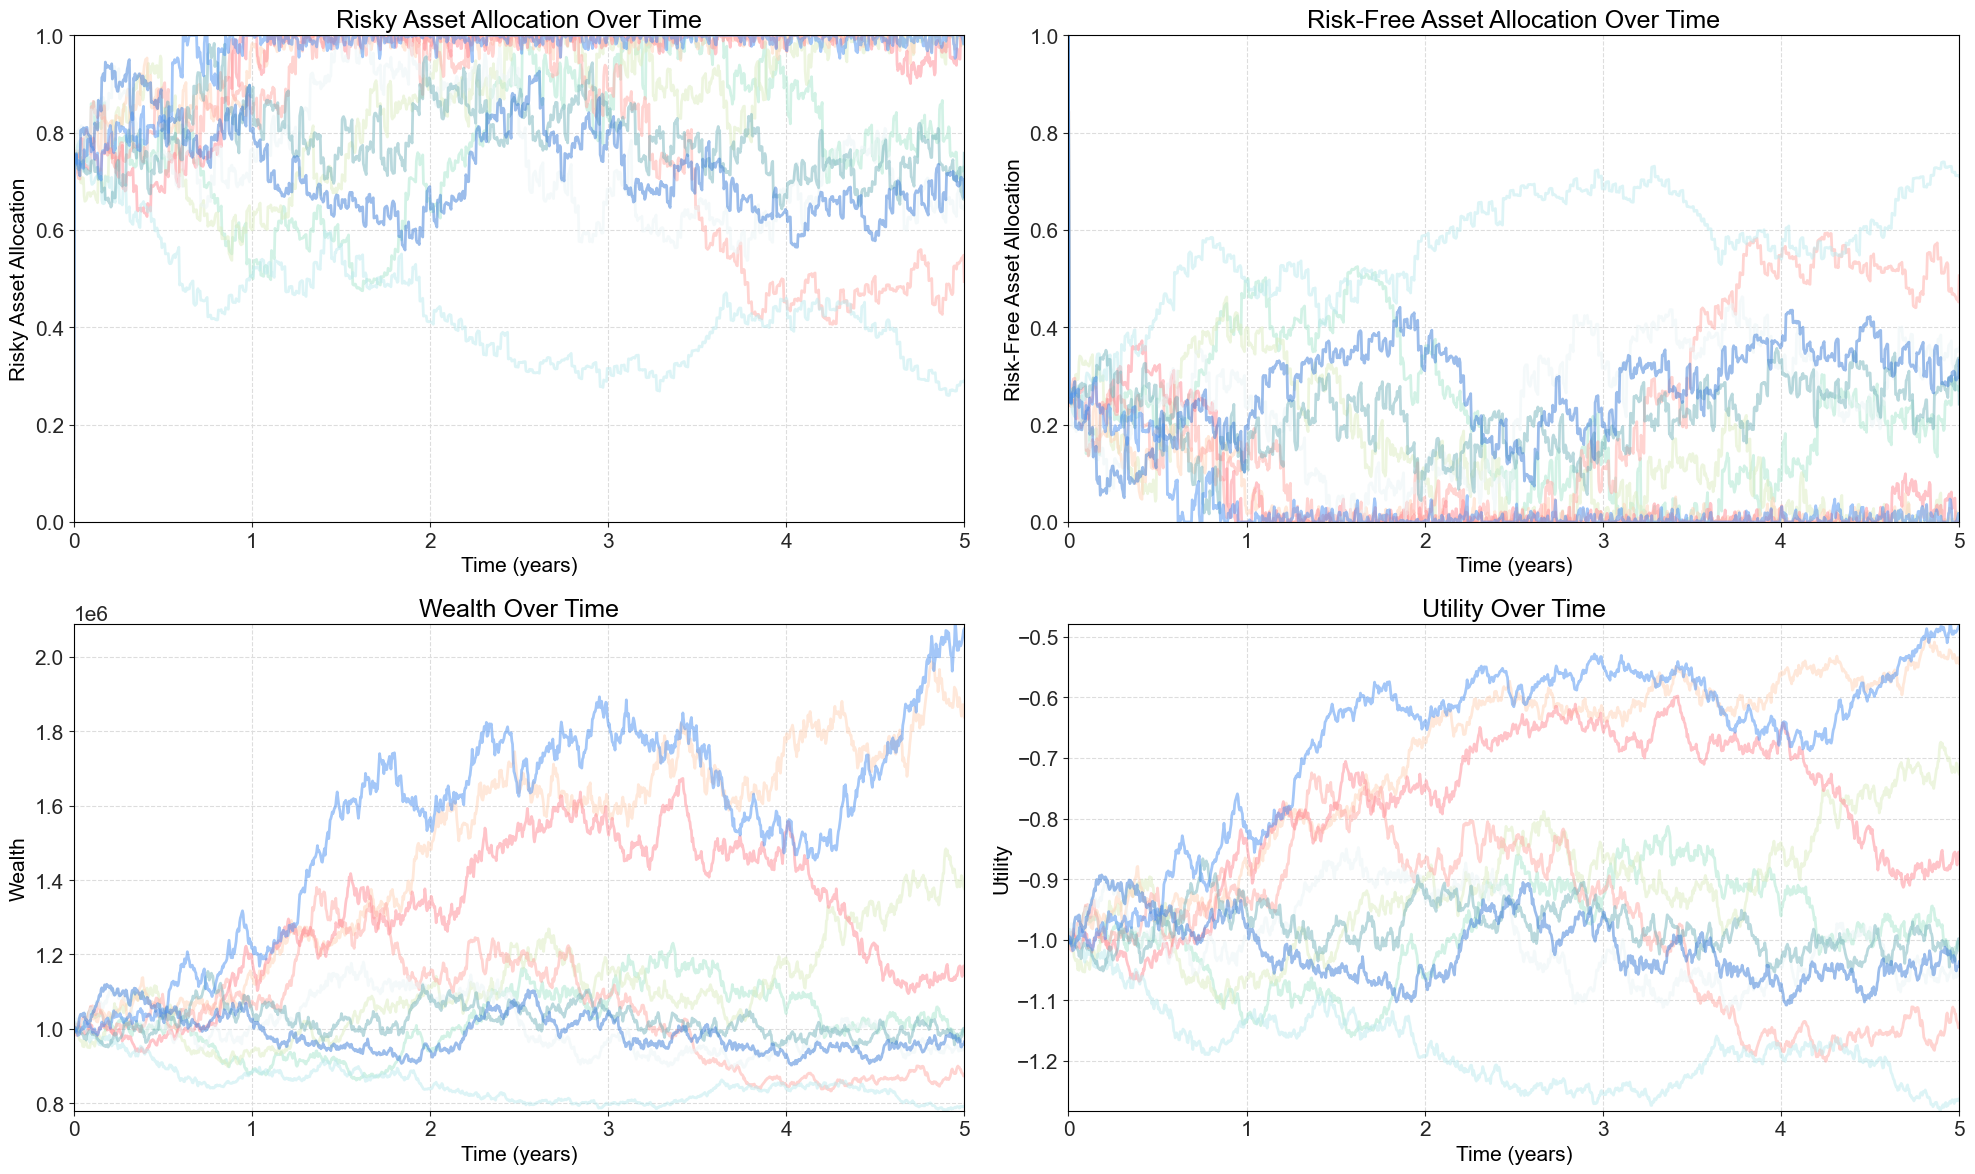

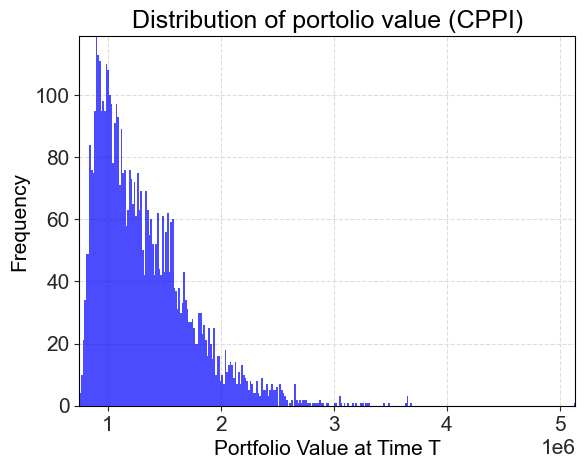

Sample mean of Portfolio at Time T=5: 1318699.5120332055
Sample variance of Portfolio at Time T=5: 177100466319.2513
Mean Risky Asset Allocation: 0.8181734758801407
Mean Risk-Free Asset Allocation: 0.18182652411986058


In [5]:
#Definition of the CPPI strategy, weekly reblancing and c=700000
def cppi_strategy(asset_prices, risk_free_rates, initial_wealth, multiplier, leverage_limit, floor_value, days_per_week):
    num_paths, num_steps = asset_prices.shape[1], asset_prices.shape[0]
    wealth = np.zeros((num_steps, num_paths))
    wealth[0, :] = initial_wealth
    hrisky_t = np.zeros((num_steps, num_paths))

    for i in range(1, num_steps):
        if i == 1 or i % days_per_week == 0:
            #If rebalancing day
            cushion = np.maximum(wealth[i - 1, :] - floor_value, 0)
            allocation = np.minimum(multiplier * cushion, leverage_limit * wealth[i - 1, :])
            hrisky_t[i, :] = np.minimum(allocation, wealth[i - 1, :])
        else:
            # If not rebalancing day
            hrisky_t[i, :] = hrisky_t[i - 1, :]

        risky_return = asset_prices[i] / asset_prices[i - 1]
        risk_free_return = risk_free_rates[i - 1] / 252
        wealth[i, :] = hrisky_t[i, :] * risky_return + (wealth[i - 1, :] - hrisky_t[i, :]) * (1 + risk_free_return)
    
    risky_allocation = hrisky_t / wealth
    risk_free_allocation = 1 - risky_allocation
    
    risky_allocation = np.clip(risky_allocation, 0, 1)
    risk_free_allocation = np.clip(risk_free_allocation, 0, 1)
    
    return wealth, risky_allocation, risk_free_allocation


final_wealth, risky_alloc, risk_free_alloc = cppi_strategy(asset_prices, risk_free_rates, W0, m, b, c, 5)

final_wealth_values = final_wealth[-1, :]

utility_over_time = crra_utility(final_wealth, gamma=2)

total_time_steps = final_wealth.shape[0]
time_in_years = np.linspace(0, 5, total_time_steps)

# Plotting the asset allocations, wealth, utility and a histogram of the final portfolio values
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Risky asset allocations
for j in range(10):
    axs[0, 0].plot(time_in_years, risky_alloc[:, j], alpha=0.5)
axs[0, 0].set_xlabel('Time (years)')
axs[0, 0].set_ylabel('Risky Asset Allocation')
axs[0, 0].set_title('Risky Asset Allocation Over Time')

# Risk-free asset allocations
for j in range(10):
    axs[0, 1].plot(time_in_years, risk_free_alloc[:, j], alpha=0.5)
axs[0, 1].set_xlabel('Time (years)')
axs[0, 1].set_ylabel('Risk-Free Asset Allocation')
axs[0, 1].set_title('Risk-Free Asset Allocation Over Time')

# Wealth
for j in range(10):
    axs[1, 0].plot(time_in_years, final_wealth[:, j], alpha=0.5)
axs[1, 0].set_xlabel('Time (years)')
axs[1, 0].set_ylabel('Wealth')
axs[1, 0].set_title('Wealth Over Time')

# Utility
for path_index in range(10):
    axs[1, 1].plot(time_in_years, utility_over_time[:, path_index], alpha=0.5)
axs[1, 1].set_xlabel('Time (years)')
axs[1, 1].set_ylabel('Utility')
axs[1, 1].set_title('Utility Over Time')
plt.tight_layout()
plt.show()


# Histogram of the final portfolio values
plt.hist(final_wealth_values, bins=300, alpha=0.7, color='blue')
plt.title('Distribution of portolio value (CPPI)')
plt.xlabel('Portfolio Value at Time T')
plt.ylabel('Frequency')
plt.show()

# Estimating the mean and variance
mean_portfolio_at_T1 = np.mean(final_wealth_values)
variance_portfolio_at_T1 = np.var(final_wealth_values)

print("Sample mean of Portfolio at Time T=5:", mean_portfolio_at_T1)
print("Sample variance of Portfolio at Time T=5:", variance_portfolio_at_T1)

# Asset allocations
mean_risky_allocation = np.mean(risky_alloc)
mean_risk_free_allocation = np.mean(risk_free_alloc)

print("Mean Risky Asset Allocation:", mean_risky_allocation)
print("Mean Risk-Free Asset Allocation:", mean_risk_free_allocation)

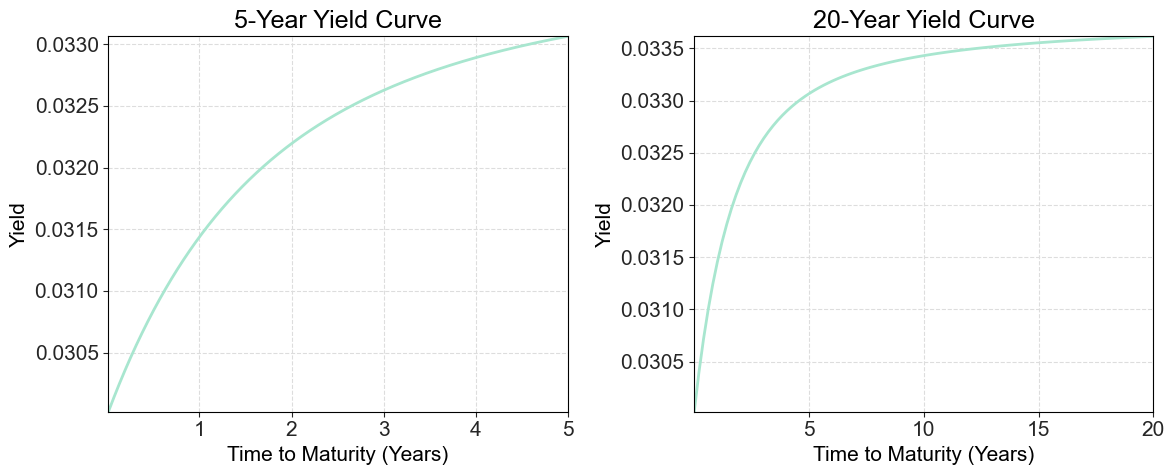

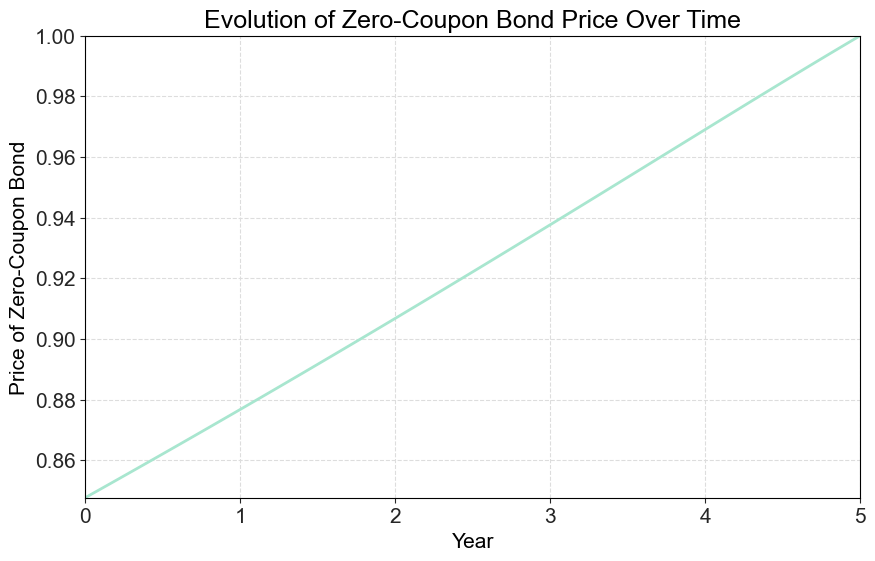

In [6]:
#Zero-coupon bond:

############## parameters ##############
kappa = 1
theta = 0.03
beta = 0.02
lambda_param = -0.2
r_0 = 0.03


############### function-definitions ################

# Define the long-term yield y_infinity
y_infinity = theta - ((lambda_param * beta) / kappa) - ((beta**2) / (2 * kappa**2))

# Define b(tau) function
def b(tau, kappa):
    return (1 - np.exp(-kappa * tau)) / kappa

# Define a(tau) function
def a(tau, kappa, beta, y_infinity):
    b_tau = b(tau, kappa)
    return y_infinity * (tau - b_tau) + (beta**2) * b_tau**2 / (4 * kappa)

# Define y(tau) function
def y(tau, kappa, beta, y_infinity, r_0):
    a_tau = a(tau, kappa, beta, y_infinity)
    b_tau = b(tau, kappa)
    return (a_tau + b_tau * r_0) / tau

# Define function for zero-coupon bond price:
def zero_coupon_bond_price(tau, kappa, beta, y_infinity, r_t):
    if tau == 0:
        return 1.0
    else:
        a_tau = a(tau, kappa, beta, y_infinity)
        b_tau = b(tau, kappa)
        return np.exp(-y(tau, kappa, beta, y_infinity, r_t) * tau)


############# Plot of the initial yield curve ##############
taus_5 = np.linspace(0.01, 5, 5000)
taus_20 = np.linspace(0.01, 20, 100)

yields_5 = [y(tau, kappa, beta, y_infinity, r_0) for tau in taus_5]
yields_20 = [y(tau, kappa, beta, y_infinity, r_0) for tau in taus_20]
# Reversing yields_5 to fit CPPI
zc_yield = np.flip(yields_5)

# Plotting the 5- and 20-year yield curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(taus_5, yields_5)
ax1.set_xlabel('Time to Maturity (Years)')
ax1.set_ylabel('Yield')
ax1.set_title('5-Year Yield Curve')

ax2.plot(taus_20, yields_20)
ax2.set_xlabel('Time to Maturity (Years)')
ax2.set_ylabel('Yield')
ax2.set_title('20-Year Yield Curve')

plt.tight_layout()
plt.show()


############ Plot of Zero Coupon bond price ############

initial_maturity = 5

times = np.linspace(0, initial_maturity, 100)
bond_prices = [zero_coupon_bond_price(initial_maturity - t, kappa, beta, y_infinity, r_0) for t in times]

plt.figure(figsize=(10, 6))
plt.plot(times, bond_prices)
plt.xlabel('Year')
plt.ylabel('Price of Zero-Coupon Bond')
plt.title('Evolution of Zero-Coupon Bond Price Over Time')
plt.show()

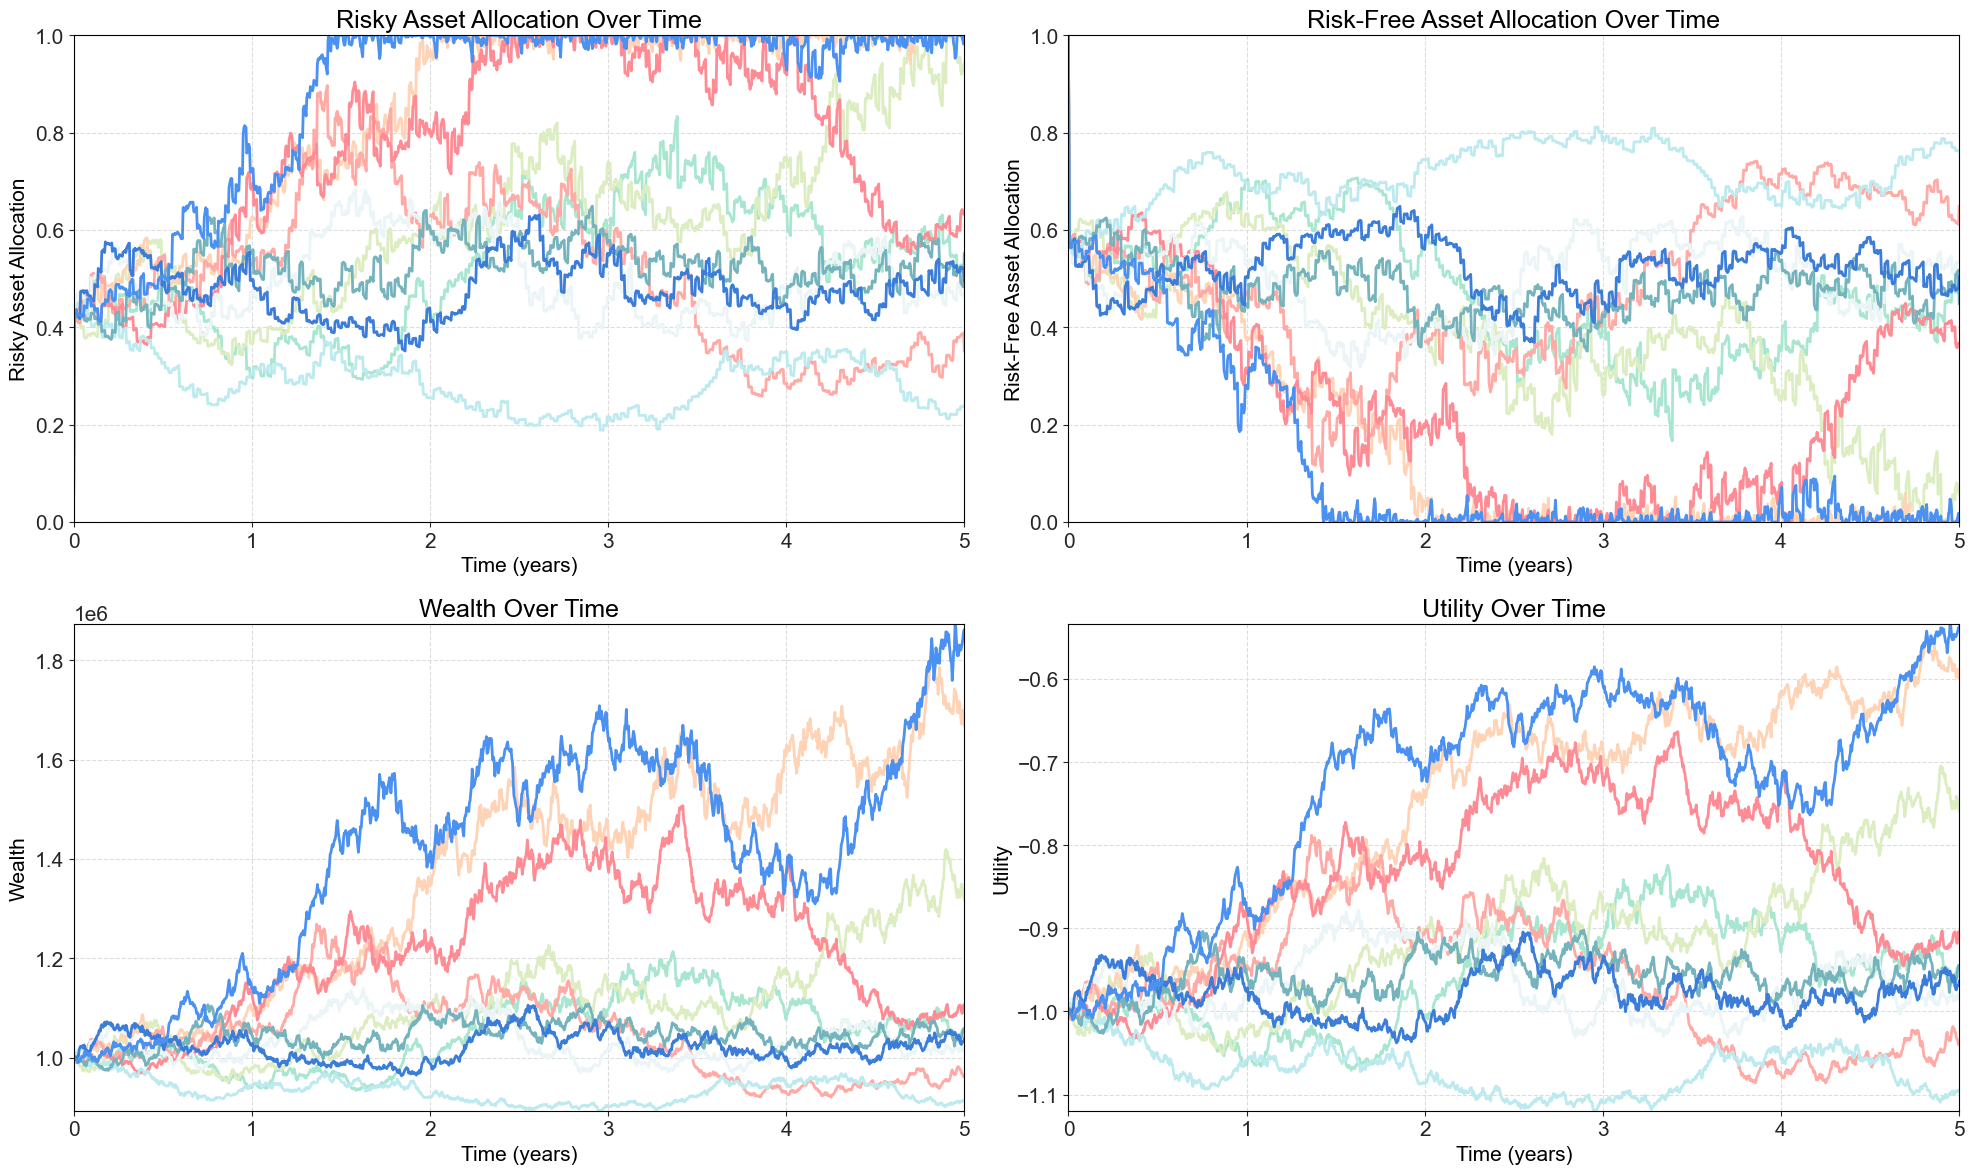

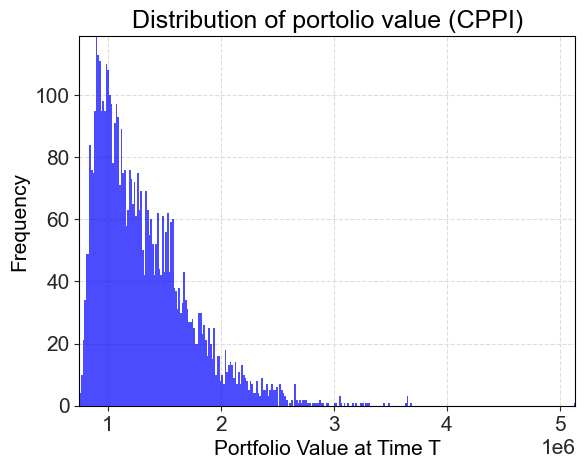

Sample mean of Portfolio weekly: 1284329.981106382
Sample variance of Portfolio weekly: 106440961879.33554
Mean Risky Asset Allocation: 0.6057002280544003
Mean Risk-Free Asset Allocation: 0.39429977194559973


In [7]:
####CPPI Zero Coupon weekly rebalancing, terminal wealth goal larger than 800000
def cppi_strategy(asset_prices, risk_free_rates, initial_wealth, multiplier, leverage_limit, floor_value, days_per_week):
    num_paths, num_steps = asset_prices.shape[1], asset_prices.shape[0]
    wealth = np.zeros((num_steps, num_paths))
    wealth[0, :] = initial_wealth
    hrisky_t = np.zeros((num_steps, num_paths))

    for i in range(1, num_steps):
        if i == 1 or i % days_per_week == 0:
            # If rebalancing day
            cushion = np.maximum(wealth[i - 1, :] - floor_value*(1+zc_yield[i % len(zc_yield)]), 0)
            allocation = np.minimum(multiplier * cushion, 1 * wealth[i - 1, :])
            hrisky_t[i, :] = np.minimum(allocation, wealth[i - 1, :])
        else:
            # If not rebalancing day
            hrisky_t[i, :] = hrisky_t[i - 1, :]

        risky_return = asset_prices[i] / asset_prices[i - 1]
        risk_free_return = (1+zc_yield[i % len(zc_yield)]/days_per_year)

        wealth[i, :] = hrisky_t[i, :] * risky_return + (wealth[i - 1, :] - hrisky_t[i, :]) * risk_free_return
    
    risky_allocation = hrisky_t / wealth
    risk_free_allocation = 1 - risky_allocation
    
    risky_allocation = np.clip(risky_allocation, 0, 1)
    risk_free_allocation = np.clip(risk_free_allocation, 0, 1)
    
    return wealth, risky_allocation, risk_free_allocation

final_wealth, risky_alloc_weekly, risk_free_alloc = cppi_strategy(asset_prices, risk_free_rates, W0, m, b, 800000, 5)

final_wealth_values_weekly = final_wealth[-1, :]

utility_over_time = crra_utility(final_wealth, gamma=2)

total_time_steps = final_wealth.shape[0]
time_in_years = np.linspace(0, 5, total_time_steps)

# Plotting the asset allocatios, wealth, utility and a histogram of the final portfolio values
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Risky asset allocations
for j in range(10):
    axs[0, 0].plot(time_in_years, risky_alloc_weekly[:, j], alpha=1)
axs[0, 0].set_xlabel('Time (years)')
axs[0, 0].set_ylabel('Risky Asset Allocation')
axs[0, 0].set_title('Risky Asset Allocation Over Time')

# Risk-free asset allocations
for j in range(10):
    axs[0, 1].plot(time_in_years, risk_free_alloc[:, j], alpha=1)
axs[0, 1].set_xlabel('Time (years)')
axs[0, 1].set_ylabel('Risk-Free Asset Allocation')
axs[0, 1].set_title('Risk-Free Asset Allocation Over Time')

# Wealth
for j in range(10):  
    axs[1, 0].plot(time_in_years, final_wealth[:, j], alpha=1)
axs[1, 0].set_xlabel('Time (years)')
axs[1, 0].set_ylabel('Wealth')
axs[1, 0].set_title('Wealth Over Time')

# Utility
for path_index in range(10):  
    axs[1, 1].plot(time_in_years, utility_over_time[:, path_index], alpha=1)
axs[1, 1].set_xlabel('Time (years)')
axs[1, 1].set_ylabel('Utility')
axs[1, 1].set_title('Utility Over Time')
plt.tight_layout()
plt.show()


# Histogram of the final portfolio value
plt.hist(final_wealth_values, bins=300, alpha=0.7, color='blue')
plt.title('Distribution of portolio value (CPPI)')
plt.xlabel('Portfolio Value at Time T')
plt.ylabel('Frequency')
plt.show()

# Estimating the mean and variance
mean_portfolio_weekly = np.mean(final_wealth_values_weekly)
variance_portfolio_weekly = np.var(final_wealth_values_weekly)

print("Sample mean of Portfolio weekly:", mean_portfolio_weekly)
print("Sample variance of Portfolio weekly:", variance_portfolio_weekly)

# Asset allocations
mean_risky_allocation = np.mean(risky_alloc_weekly)
mean_risk_free_allocation = np.mean(risk_free_alloc)

print("Mean Risky Asset Allocation:", mean_risky_allocation)
print("Mean Risk-Free Asset Allocation:", mean_risk_free_allocation)

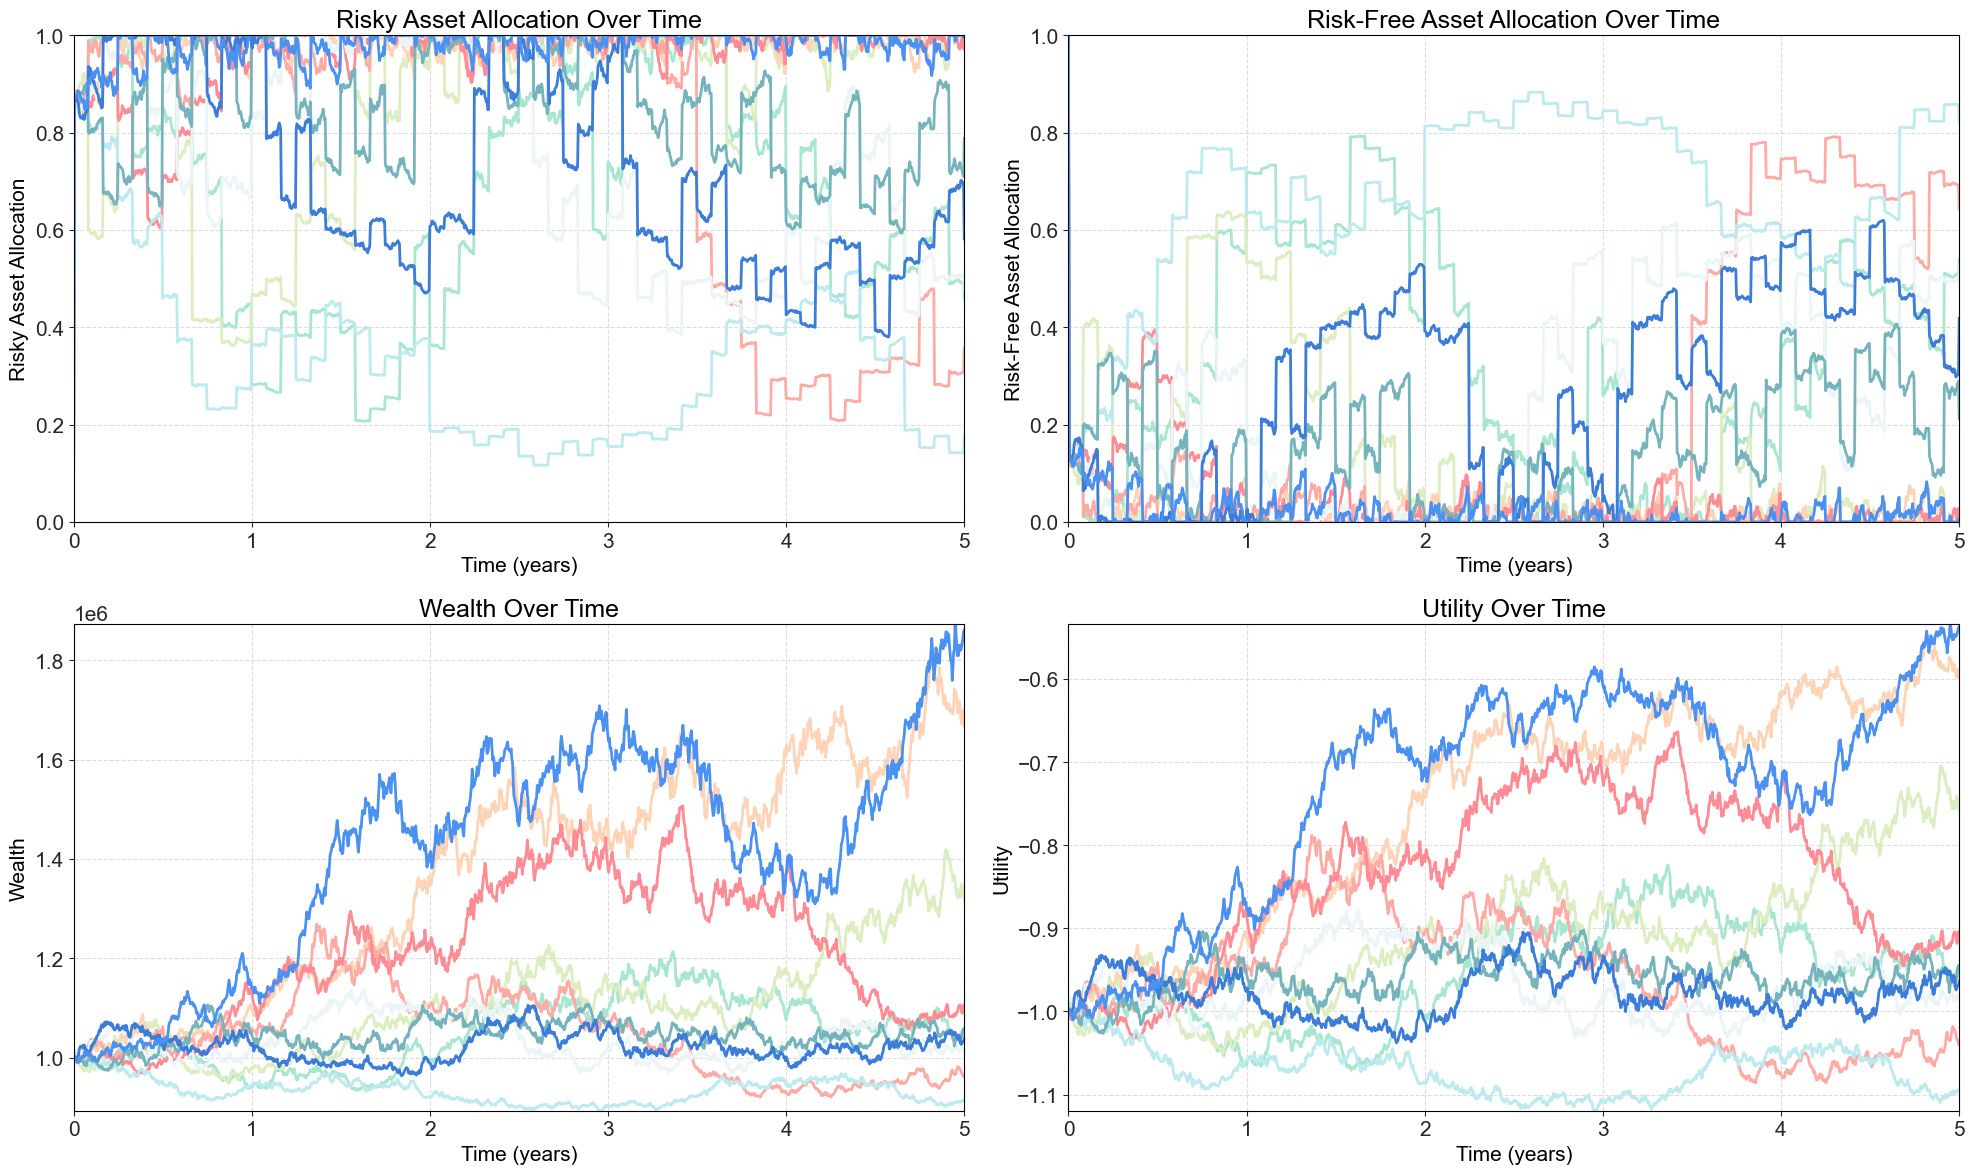

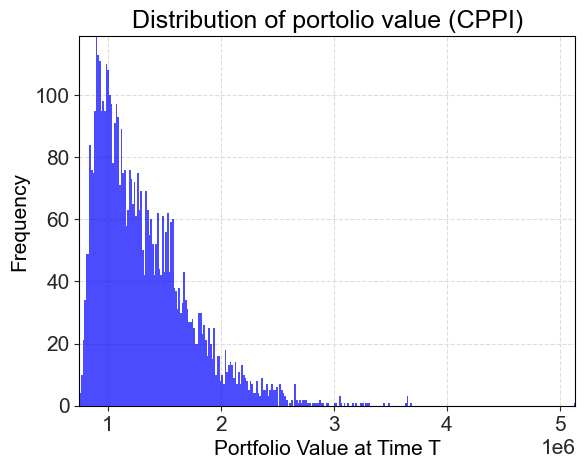

Sample mean of Portfolio monthly: 1324288.845040912
Sample variance of Portfolio monthly: 187660429228.40775
Mean Risky Asset Allocation: 0.8119896547743144
Mean Risk-Free Asset Allocation: 0.188010345225686


In [9]:
####CPI Zero Coupon monthly rebalancing m=5
def cppi_strategy(asset_prices, risk_free_rates, initial_wealth, multiplier, leverage_limit, floor_value, days_per_month):
    num_paths, num_steps = asset_prices.shape[1], asset_prices.shape[0]
    wealth = np.zeros((num_steps, num_paths))
    wealth[0, :] = initial_wealth
    hrisky_t = np.zeros((num_steps, num_paths))

    for i in range(1, num_steps):
        if i == 1 or i % days_per_month == 0:
            # If rebalancing day
            cushion = np.maximum(wealth[i - 1, :] - floor_value*(1+zc_yield[i % len(zc_yield)]), 0)
            allocation = np.minimum(multiplier * cushion, leverage_limit * wealth[i - 1, :])
            hrisky_t[i, :] = np.minimum(allocation, wealth[i - 1, :])
        else:
            # If not rebalancing day
            hrisky_t[i, :] = hrisky_t[i - 1, :]

        risky_return = asset_prices[i] / asset_prices[i - 1]
        risk_free_return = (1+zc_yield[i % len(zc_yield)]/days_per_year)

        wealth[i, :] = hrisky_t[i, :] * risky_return + (wealth[i - 1, :] - hrisky_t[i, :]) * risk_free_return
    
    risky_allocation = hrisky_t / wealth
    risk_free_allocation = 1 - risky_allocation
    
    risky_allocation = np.clip(risky_allocation, 0, 1)
    risk_free_allocation = np.clip(risk_free_allocation, 0, 1)
    
    return wealth, risky_allocation, risk_free_allocation

final_wealth_monthly, risky_alloc_month, risk_free_alloc = cppi_strategy(asset_prices, risk_free_rates, W0, 5, 1, 800000, days_per_month)

final_wealth_monthly = final_wealth_monthly[-1, :]

utility_over_time = crra_utility(final_wealth, gamma=2)

total_time_steps = final_wealth.shape[0]
time_in_years = np.linspace(0, 5, total_time_steps)

# Plotting the asset allocations, wealth, utility and a histogram of the final portfolio value
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Risky asset allocations
for j in range(10): 
    axs[0, 0].plot(time_in_years, risky_alloc_month[:, j], alpha=1)
axs[0, 0].set_xlabel('Time (years)')
axs[0, 0].set_ylabel('Risky Asset Allocation')
axs[0, 0].set_title('Risky Asset Allocation Over Time')

# Risk-free asset allocations
for j in range(10):
    axs[0, 1].plot(time_in_years, risk_free_alloc[:, j], alpha=1)
axs[0, 1].set_xlabel('Time (years)')
axs[0, 1].set_ylabel('Risk-Free Asset Allocation')
axs[0, 1].set_title('Risk-Free Asset Allocation Over Time')

# Wealth
for j in range(10):
    axs[1, 0].plot(time_in_years, final_wealth[:, j], alpha=1)
axs[1, 0].set_xlabel('Time (years)')
axs[1, 0].set_ylabel('Wealth')
axs[1, 0].set_title('Wealth Over Time')

# Utility
for path_index in range(10):
    axs[1, 1].plot(time_in_years, utility_over_time[:, path_index], alpha=1)
axs[1, 1].set_xlabel('Time (years)')
axs[1, 1].set_ylabel('Utility')
axs[1, 1].set_title('Utility Over Time')
plt.tight_layout()
plt.show()

# Histogram of the final Portfolio value
plt.hist(final_wealth_values, bins=300, alpha=0.7, color='blue')
plt.title('Distribution of portolio value (CPPI)')
plt.xlabel('Portfolio Value at Time T')
plt.ylabel('Frequency')
plt.show()

# Estimating the mean and variance
mean_portfolio_monthly = np.mean(final_wealth_monthly)
variance_portfolio_monthly = np.var(final_wealth_monthly)

print("Sample mean of Portfolio monthly:", mean_portfolio_monthly)
print("Sample variance of Portfolio monthly:", variance_portfolio_monthly)

# Asset allocations
mean_risky_allocation = np.mean(risky_alloc_month)
mean_risk_free_allocation = np.mean(risk_free_alloc)

print("Mean Risky Asset Allocation:", mean_risky_allocation)
print("Mean Risk-Free Asset Allocation:", mean_risk_free_allocation)

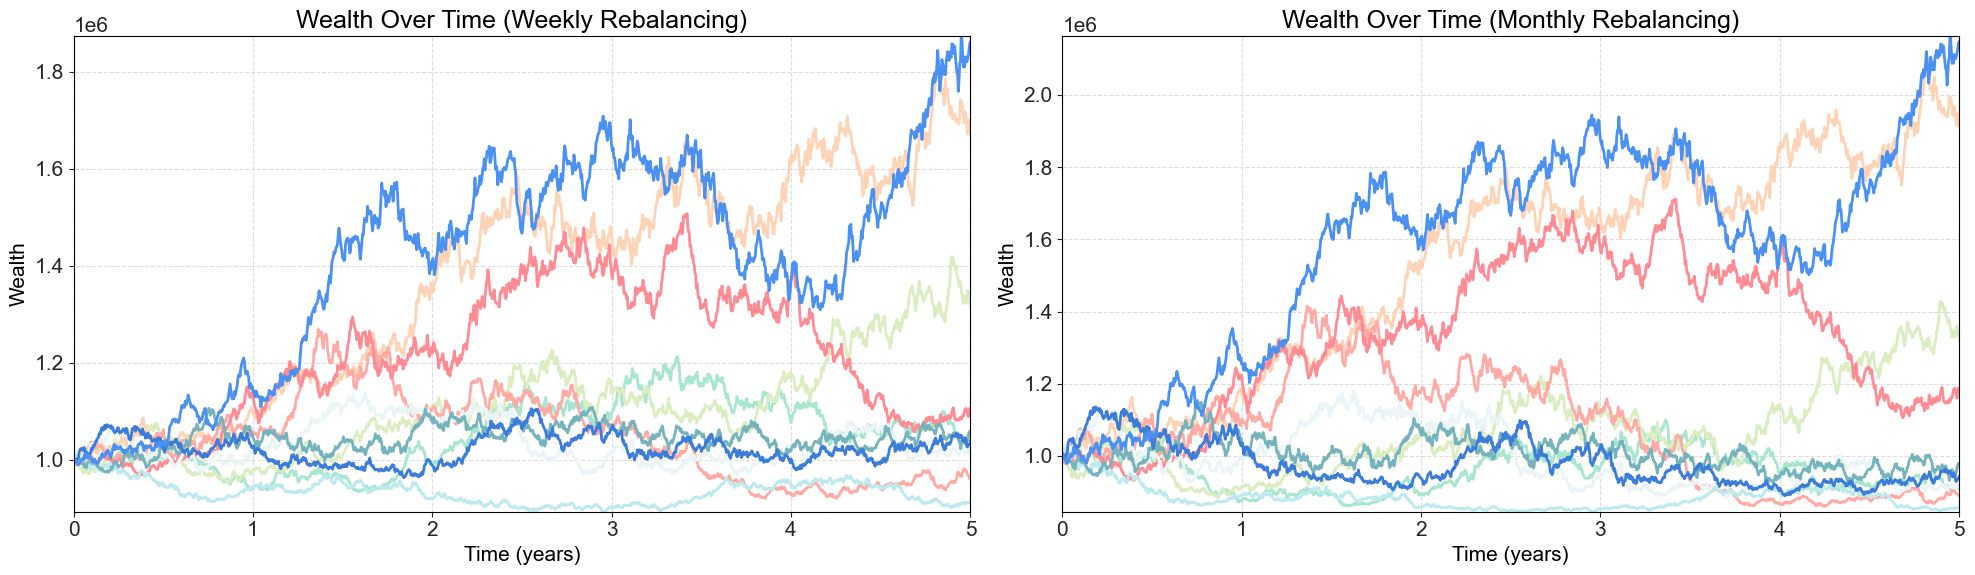

In [11]:
#Plotting the evolution of wealth for the weekly and monthly rebalancing

# Weekly rebalancing
final_wealth_weekly, risky_alloc_weekly, risk_free_alloc_weekly = cppi_strategy(asset_prices, risk_free_rates, W0, m, 1, 800000, days_per_week)

# Monthly rebalancing
final_wealth_monthly, risky_alloc_monthly, risk_free_alloc_monthly = cppi_strategy(asset_prices, risk_free_rates, W0, 5, 1, 800000, days_per_month)

final_wealth_values_weekly = final_wealth_weekly[-1, :]
final_wealth_values_monthly = final_wealth_monthly[-1, :]

total_time_steps = final_wealth_weekly.shape[0]
time_in_years = np.linspace(0, 5, total_time_steps)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Weekly
for j in range(10):
    axs[0].plot(time_in_years, final_wealth_weekly[:, j], alpha=1)
axs[0].set_xlabel('Time (years)')
axs[0].set_ylabel('Wealth')
axs[0].set_title('Wealth Over Time (Weekly Rebalancing)')

# Monthly
for j in range(10):
    axs[1].plot(time_in_years, final_wealth_monthly[:, j], alpha=1)
axs[1].set_xlabel('Time (years)')
axs[1].set_ylabel('Wealth')
axs[1].set_title('Wealth Over Time (Monthly Rebalancing)')

plt.tight_layout()
plt.show()

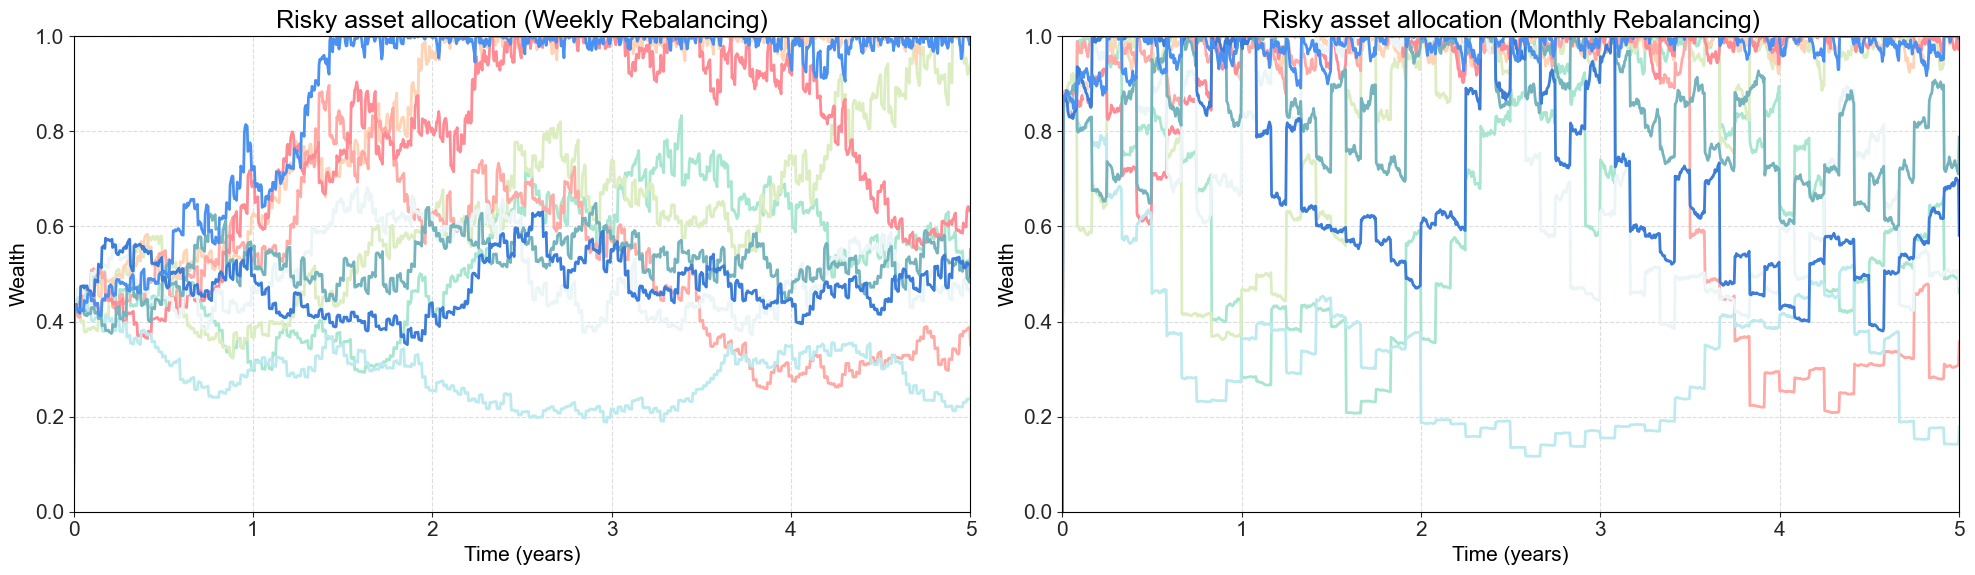

In [13]:
# Plotting asset allocations for the weekly and monthly rebalancing
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Weekly
for j in range(10):
    axs[0].plot(time_in_years, risky_alloc_weekly[:, j], alpha=1)
axs[0].set_xlabel('Time (years)')
axs[0].set_ylabel('Wealth')
axs[0].set_title('Risky asset allocation (Weekly Rebalancing)')

# Monthly
for j in range(10):
    axs[1].plot(time_in_years, risky_alloc_month[:, j], alpha=1)
axs[1].set_xlabel('Time (years)')
axs[1].set_ylabel('Wealth')
axs[1].set_title('Risky asset allocation (Monthly Rebalancing)')

plt.tight_layout()
plt.show()